In [1]:
import torch
from graphdiff import Graph
import numpy

## Utility Functions and basic example on random graphs

In [2]:
def erdos_renyi(V: int, p: float, device:str = 'cpu') -> Graph:
    """
    Create a random Erdos-Renyi graph.
    ## Args:
    - V: Number of vertices
    - p: Probability of having an edge between two vertices.
    - device: Device on which to store the graph
    ## Returns:
    Erdos-Renyi Graph
    """

    adj = torch.zeros((V,V))
    for i in range(V):
        for j in range(i+1,V):
            adj[i,j] =int(numpy.random.choice([0,1],1,[p,1-p]))
            adj[j,i] = adj[i,j]

    return Graph(adj, device)

In [3]:
V = 10
p = 0.8
DEVICE = 'cuda'

In [4]:
graph = erdos_renyi(V,p,DEVICE)

/tmp/ipykernel_56845/2706878946.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  adj[i,j] =int(numpy.random.choice([0,1],1,[p,1-p]))
/home/adrien/gnn-dynamical-systems/.env/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


### Working on the Graph

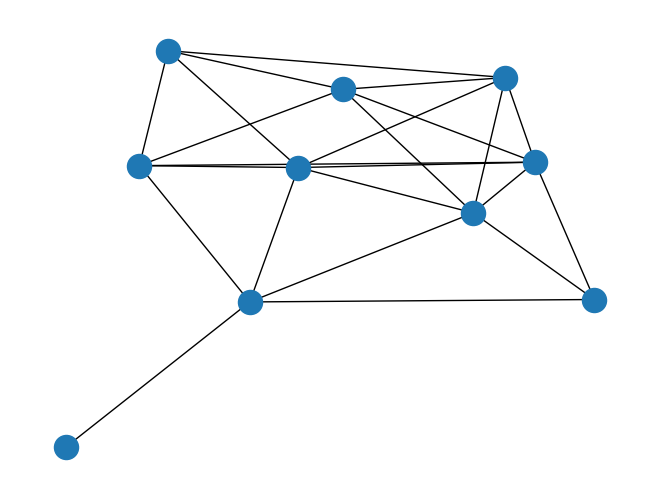

In [5]:
graph.visualize()

In [6]:
print("--------- LAPLACIAN FREQUENCIES ----------")
print(torch.abs(torch.round(graph.get_frequencies(type='normal'), decimals=3)).cpu().numpy())
print()
print()

print("--------- NORMALIZED LAPLACIAN FREQUENCIES ----------")
print(torch.abs(torch.round(graph.get_frequencies(type='normalized'), decimals=3)).cpu().numpy())
print()
print()

print("--------- NORMALIZED AUGMENTED LAPLACIAN FREQUENCIES ----------")
print(torch.abs(torch.round(graph.get_frequencies(type='augmented_normalized'), decimals=3)).cpu().numpy())

--------- LAPLACIAN FREQUENCIES ----------
[0.    0.859 2.428 4.336 4.67  5.14  6.    6.906 7.771 7.891]


--------- NORMALIZED LAPLACIAN FREQUENCIES ----------
[0.    0.496 0.729 0.964 1.    1.14  1.194 1.382 1.463 1.633]


--------- NORMALIZED AUGMENTED LAPLACIAN FREQUENCIES ----------
[0.    0.331 0.548 0.753 0.828 0.913 0.965 1.12  1.211 1.286]


### Signal Analysis on the Graph

In [7]:
SIGNAL = torch.randn((V,1))

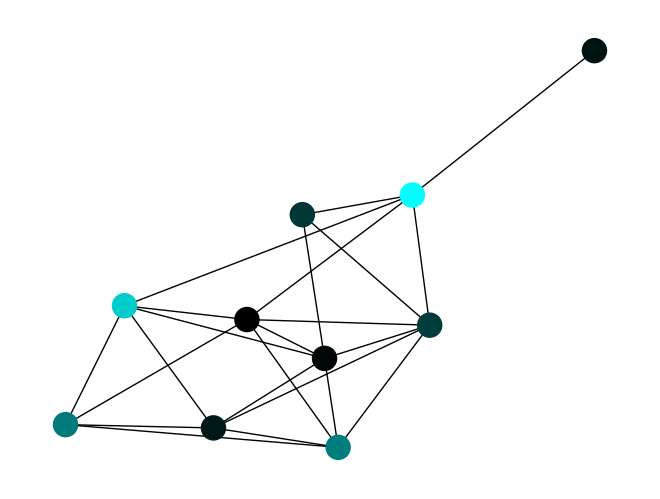

In [8]:
graph.visualize_signal(SIGNAL)

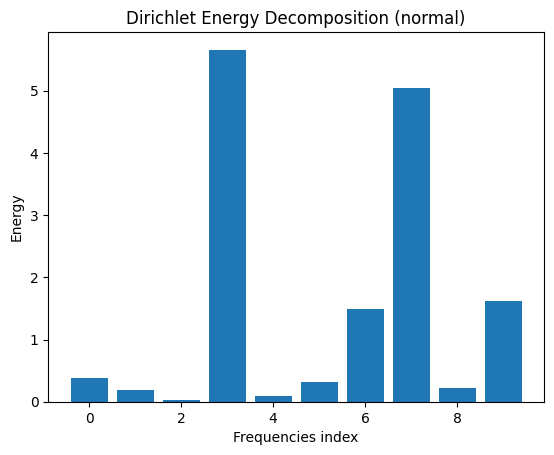

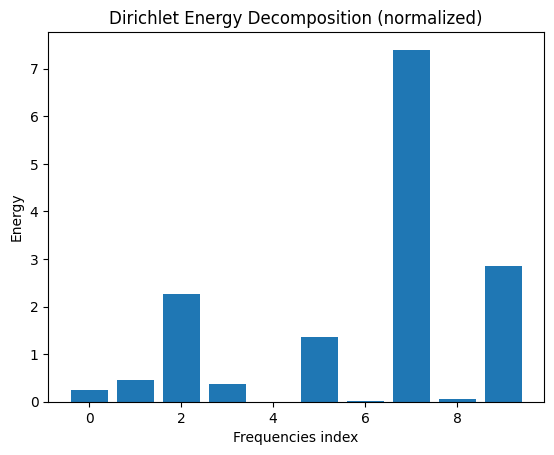

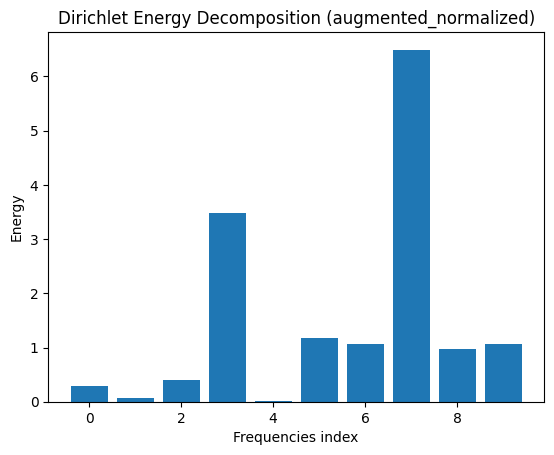

In [9]:
graph.visualize_energy_decomposition(SIGNAL, type='normal')
graph.visualize_energy_decomposition(SIGNAL, type='normalized')
graph.visualize_energy_decomposition(SIGNAL, type='augmented_normalized')

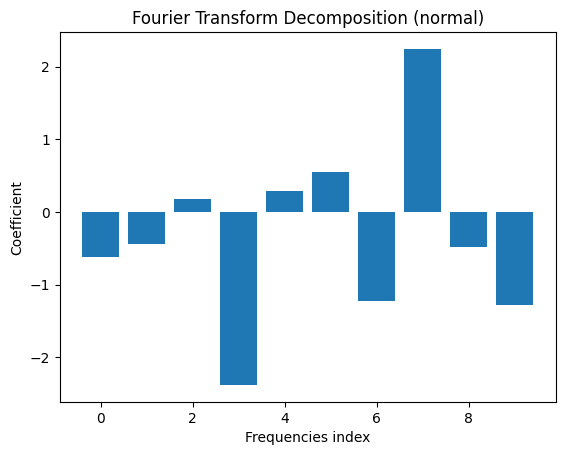

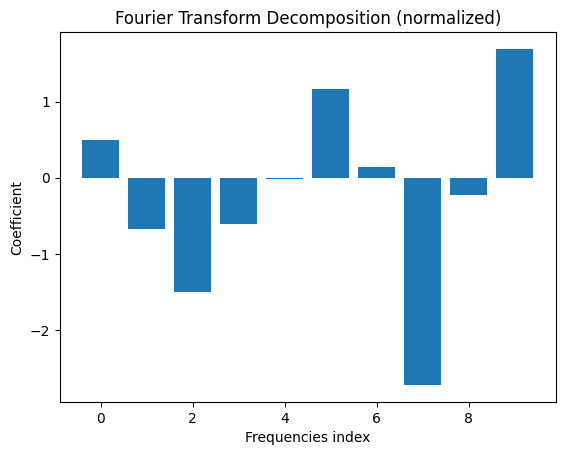

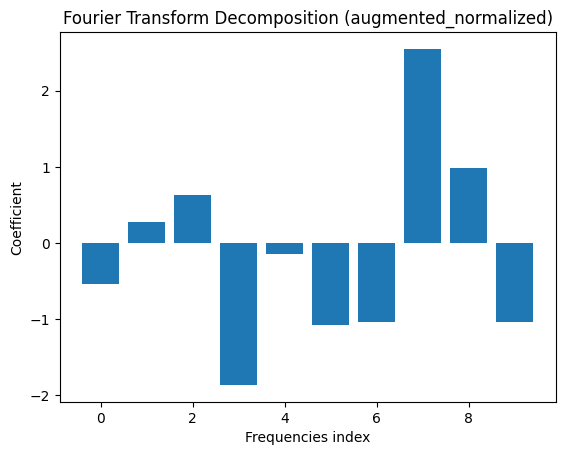

In [10]:
graph.visualize_ft(SIGNAL, type='normal')
graph.visualize_ft(SIGNAL, type='normalized')
graph.visualize_ft(SIGNAL, type='augmented_normalized')

In [11]:
print(f'Dirirchlet Energy (Normal): {graph.energy(SIGNAL, "normal")}')
print(f'Dirirchlet Energy (Normalized): {graph.energy(SIGNAL, "normalized")}')
print(f'Dirirchlet Energy (Augmented Normalized): {graph.energy(SIGNAL, "augmented_normalized")}')

Dirirchlet Energy (Normal): 9.221020228276965
Dirirchlet Energy (Normalized): 4.333279951696002
Dirirchlet Energy (Augmented Normalized): 3.8470270097387758


In [12]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [25]:

LAPLACIAN = graph.laplacian.cpu().numpy()

def diffusion(signal,t):
    return -signal@LAPLACIAN


res = odeint(diffusion, SIGNAL.flatten().cpu().numpy(), numpy.linspace(0,2,1000))

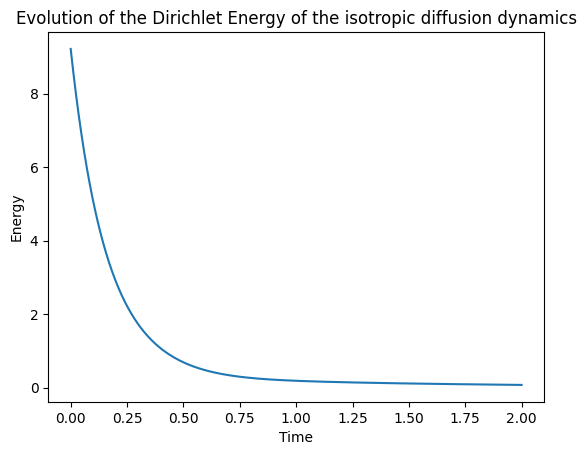

In [26]:
energy = []
for i in range(0,len(res)):
    signal = torch.from_numpy(res.T)[:,i:i+1].float()
    energy.append(graph.energy(signal, type = 'normal'))

plt.plot(numpy.linspace(0,2,1000),energy)
plt.title("Evolution of the Dirichlet Energy of the isotropic diffusion dynamics")
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

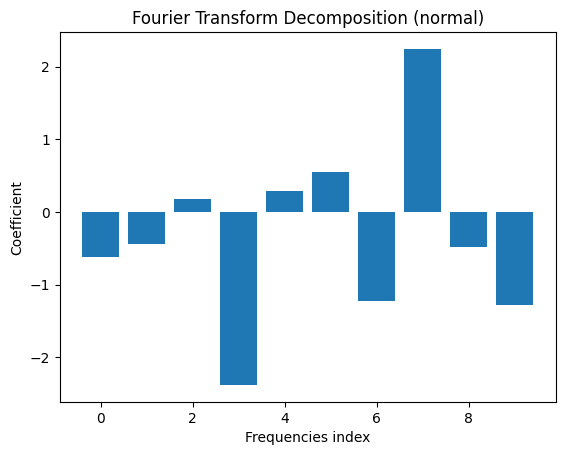

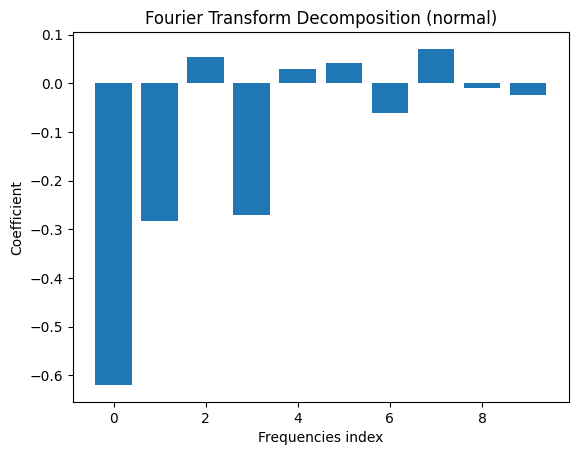

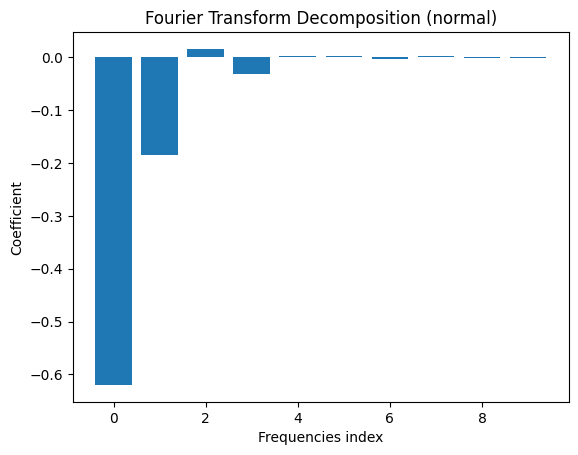

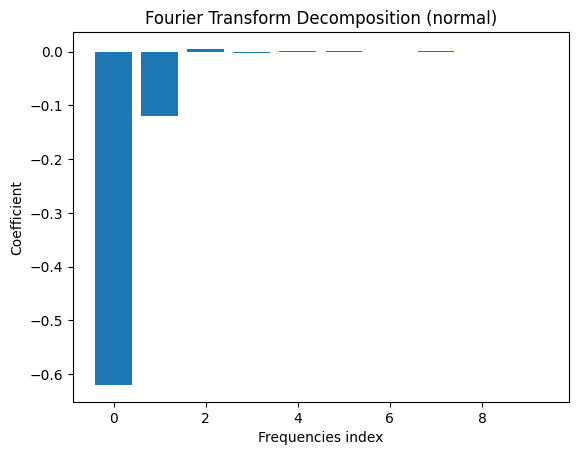

In [15]:
for i in range(0,1000,250):
    graph.visualize_ft(torch.from_numpy(res[i:i+1,:]).float().T, 'normal')

### Anisotropic Positive Diffusion process

In [16]:
# similarity function
def similarity(signal, i:int, j:int) -> float:
    return 1/(1 + float((signal[i] - signal[j])**2))

In [17]:
def M(signal: numpy.ndarray) -> numpy.ndarray:
    mat = numpy.zeros(shape = (V,V))
    for i in range(V):
        for j in range(V):
            mat[i,j] = similarity(signal,i,j)
    return mat

In [18]:
LAPLACIAN = graph.laplacian.cpu().numpy()

def diffusion(signal,t):
    return -signal@(LAPLACIAN*M(signal))


res = odeint(diffusion, SIGNAL.flatten().cpu().numpy(), numpy.linspace(0,2,1000))

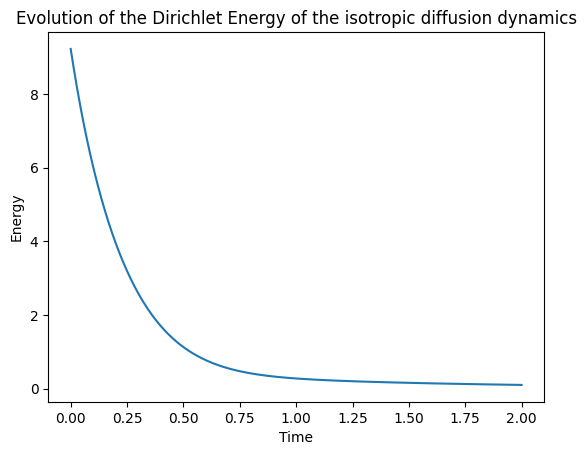

In [19]:
energy = []
for i in range(0,len(res)):
    signal = torch.from_numpy(res.T)[:,i:i+1].float()
    energy.append(graph.energy(signal, type = 'normal'))

plt.plot(numpy.linspace(0,2,1000),energy)
plt.title("Evolution of the Dirichlet Energy of the isotropic diffusion dynamics")
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

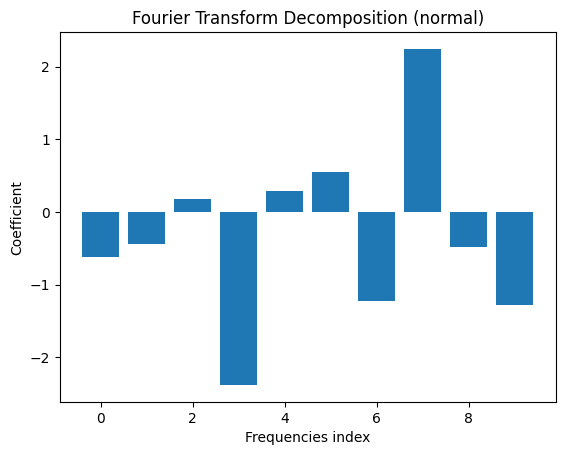

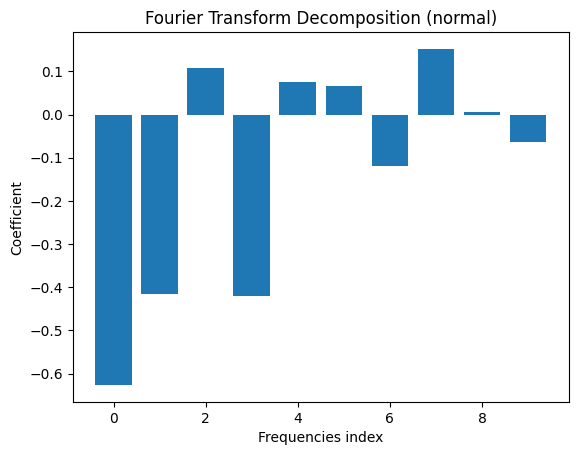

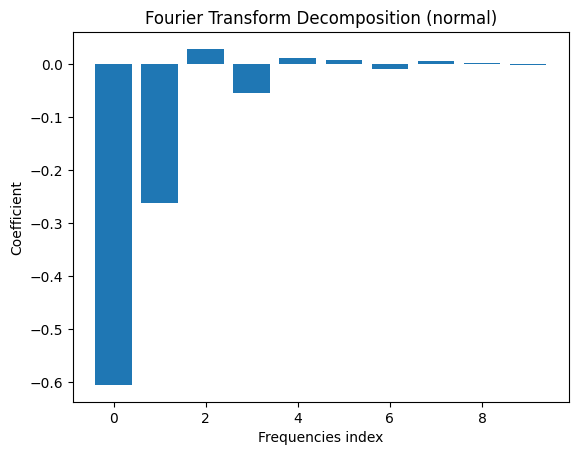

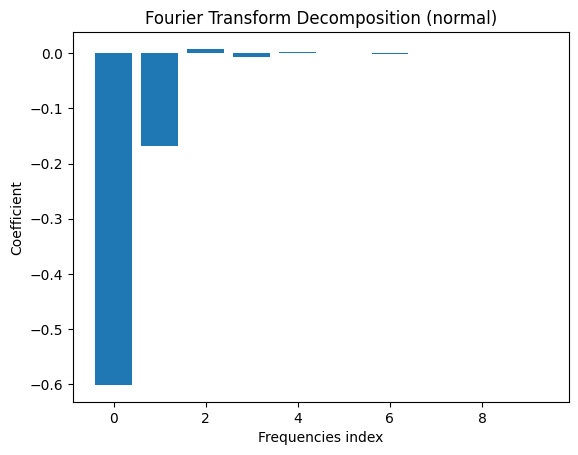

In [20]:
for i in range(0,1000,250):
    graph.visualize_ft(torch.from_numpy(res[i:i+1,:]).float().T, 'normal')

### Anisotropic Diffusion Process

In [21]:
# similarity function
def similarity(signal, i:int, j:int) -> float:
    return 1/(1 + float((signal[i] - signal[j])**2))

In [22]:
def M(signal: numpy.ndarray, t) -> numpy.ndarray:
    mat = numpy.zeros(shape = (V,V))
    for i in range(V):
        for j in range(V):
            mat[i,j] = similarity(signal,i,j) - t
    return mat

In [23]:
LAPLACIAN = graph.laplacian.cpu().numpy()

def diffusion(signal,t):
    return -signal@(LAPLACIAN*M(signal,t))


res = odeint(diffusion, SIGNAL.flatten().cpu().numpy(), numpy.linspace(0,2,1000))

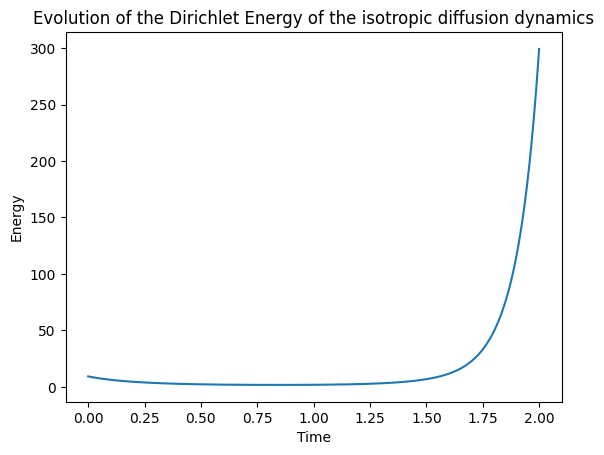

In [24]:
energy = []
for i in range(0,len(res)):
    signal = torch.from_numpy(res.T)[:,i:i+1].float()
    energy.append(graph.energy(signal, type = 'normal'))

plt.plot(numpy.linspace(0,2,1000),energy)
plt.title("Evolution of the Dirichlet Energy of the isotropic diffusion dynamics")
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()